# HAR CNN + LSTM training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="./data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="./data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Standardize
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train,
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
lstm_size = 27         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 60       # Batch size  #600 -> 60
seq_len = 128          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 100           #1000 -> 100

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layer(s)

Questions: 
* Should we use a different activation? Like tf.nn.tanh?
* Should we use pooling? average or max?

In [9]:
# Convolutional layers
with graph.as_default():
    # (batch, 128, 9) --> (batch, 128, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    n_ch = n_channels *2
    

Now, pass to LSTM cells

In [10]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(conv1, [1,0,2]) # reshape into (seq_len, batch, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_ch]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass and cost function:

In [11]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [12]:
if (os.path.exists('checkpoints-crnn') == False):
    !mkdir checkpoints-crnn

In [13]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%25 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-crnn/har.ckpt")

Epoch: 0/100 Iteration: 5 Train loss: 1.800087 Train acc: 0.066667
Epoch: 0/100 Iteration: 10 Train loss: 1.803643 Train acc: 0.200000
Epoch: 0/100 Iteration: 15 Train loss: 1.793240 Train acc: 0.133333
Epoch: 0/100 Iteration: 20 Train loss: 1.802514 Train acc: 0.100000
Epoch: 0/100 Iteration: 25 Train loss: 1.774164 Train acc: 0.116667
Epoch: 0/100 Iteration: 25 Validation loss: 1.771523 Validation acc: 0.146111
Epoch: 0/100 Iteration: 30 Train loss: 1.794363 Train acc: 0.150000
Epoch: 0/100 Iteration: 35 Train loss: 1.739293 Train acc: 0.283333
Epoch: 0/100 Iteration: 40 Train loss: 1.753462 Train acc: 0.200000
Epoch: 0/100 Iteration: 45 Train loss: 1.767268 Train acc: 0.150000
Epoch: 0/100 Iteration: 50 Train loss: 1.739193 Train acc: 0.266667
Epoch: 0/100 Iteration: 50 Validation loss: 1.744610 Validation acc: 0.182222
Epoch: 0/100 Iteration: 55 Train loss: 1.748712 Train acc: 0.100000
Epoch: 0/100 Iteration: 60 Train loss: 1.747602 Train acc: 0.216667
Epoch: 0/100 Iteration: 65 Tr

Epoch: 5/100 Iteration: 495 Train loss: 1.034552 Train acc: 0.500000
Epoch: 5/100 Iteration: 500 Train loss: 0.821495 Train acc: 0.700000
Epoch: 5/100 Iteration: 500 Validation loss: 0.805512 Validation acc: 0.695000
Epoch: 5/100 Iteration: 505 Train loss: 0.918523 Train acc: 0.666667
Epoch: 5/100 Iteration: 510 Train loss: 0.946242 Train acc: 0.600000
Epoch: 5/100 Iteration: 515 Train loss: 0.846702 Train acc: 0.650000
Epoch: 5/100 Iteration: 520 Train loss: 0.829556 Train acc: 0.666667
Epoch: 5/100 Iteration: 525 Train loss: 0.840999 Train acc: 0.616667
Epoch: 5/100 Iteration: 525 Validation loss: 0.783587 Validation acc: 0.695556
Epoch: 5/100 Iteration: 530 Train loss: 0.910737 Train acc: 0.616667
Epoch: 5/100 Iteration: 535 Train loss: 0.966882 Train acc: 0.533333
Epoch: 5/100 Iteration: 540 Train loss: 0.815201 Train acc: 0.650000
Epoch: 5/100 Iteration: 545 Train loss: 0.917328 Train acc: 0.616667
Epoch: 6/100 Iteration: 550 Train loss: 0.807227 Train acc: 0.750000
Epoch: 6/100 I

Epoch: 10/100 Iteration: 975 Validation loss: 0.618583 Validation acc: 0.707778
Epoch: 10/100 Iteration: 980 Train loss: 0.604625 Train acc: 0.766667
Epoch: 10/100 Iteration: 985 Train loss: 0.664813 Train acc: 0.700000
Epoch: 10/100 Iteration: 990 Train loss: 0.781189 Train acc: 0.666667
Epoch: 10/100 Iteration: 995 Train loss: 0.662209 Train acc: 0.666667
Epoch: 10/100 Iteration: 1000 Train loss: 0.663596 Train acc: 0.716667
Epoch: 10/100 Iteration: 1000 Validation loss: 0.611914 Validation acc: 0.709444
Epoch: 11/100 Iteration: 1005 Train loss: 0.606110 Train acc: 0.816667
Epoch: 11/100 Iteration: 1010 Train loss: 0.670274 Train acc: 0.783333
Epoch: 11/100 Iteration: 1015 Train loss: 0.557966 Train acc: 0.833333
Epoch: 11/100 Iteration: 1020 Train loss: 0.775769 Train acc: 0.666667
Epoch: 11/100 Iteration: 1025 Train loss: 0.641738 Train acc: 0.700000
Epoch: 11/100 Iteration: 1025 Validation loss: 0.605479 Validation acc: 0.699445
Epoch: 11/100 Iteration: 1030 Train loss: 0.531101 T

Epoch: 15/100 Iteration: 1450 Train loss: 0.558452 Train acc: 0.800000
Epoch: 15/100 Iteration: 1450 Validation loss: 0.510938 Validation acc: 0.821111
Epoch: 15/100 Iteration: 1455 Train loss: 0.540561 Train acc: 0.766667
Epoch: 16/100 Iteration: 1460 Train loss: 0.543743 Train acc: 0.766667
Epoch: 16/100 Iteration: 1465 Train loss: 0.679466 Train acc: 0.733333
Epoch: 16/100 Iteration: 1470 Train loss: 0.536789 Train acc: 0.800000
Epoch: 16/100 Iteration: 1475 Train loss: 0.589660 Train acc: 0.783333
Epoch: 16/100 Iteration: 1475 Validation loss: 0.507515 Validation acc: 0.831111
Epoch: 16/100 Iteration: 1480 Train loss: 0.586060 Train acc: 0.700000
Epoch: 16/100 Iteration: 1485 Train loss: 0.505666 Train acc: 0.866667
Epoch: 16/100 Iteration: 1490 Train loss: 0.662018 Train acc: 0.716667
Epoch: 16/100 Iteration: 1495 Train loss: 0.573227 Train acc: 0.750000
Epoch: 16/100 Iteration: 1500 Train loss: 0.639283 Train acc: 0.750000
Epoch: 16/100 Iteration: 1500 Validation loss: 0.494648 V

Epoch: 21/100 Iteration: 1920 Train loss: 0.515009 Train acc: 0.800000
Epoch: 21/100 Iteration: 1925 Train loss: 0.410192 Train acc: 0.866667
Epoch: 21/100 Iteration: 1925 Validation loss: 0.427975 Validation acc: 0.866111
Epoch: 21/100 Iteration: 1930 Train loss: 0.618399 Train acc: 0.733333
Epoch: 21/100 Iteration: 1935 Train loss: 0.449563 Train acc: 0.833333
Epoch: 21/100 Iteration: 1940 Train loss: 0.450497 Train acc: 0.850000
Epoch: 21/100 Iteration: 1945 Train loss: 0.622572 Train acc: 0.733333
Epoch: 21/100 Iteration: 1950 Train loss: 0.512538 Train acc: 0.800000
Epoch: 21/100 Iteration: 1950 Validation loss: 0.434452 Validation acc: 0.863334
Epoch: 21/100 Iteration: 1955 Train loss: 0.429060 Train acc: 0.816667
Epoch: 21/100 Iteration: 1960 Train loss: 0.601759 Train acc: 0.733333
Epoch: 21/100 Iteration: 1965 Train loss: 0.408355 Train acc: 0.866667
Epoch: 21/100 Iteration: 1970 Train loss: 0.425866 Train acc: 0.816667
Epoch: 21/100 Iteration: 1975 Train loss: 0.573393 Train 

Epoch: 26/100 Iteration: 2390 Train loss: 0.341355 Train acc: 0.916667
Epoch: 26/100 Iteration: 2395 Train loss: 0.324691 Train acc: 0.883333
Epoch: 26/100 Iteration: 2400 Train loss: 0.463709 Train acc: 0.833333
Epoch: 26/100 Iteration: 2400 Validation loss: 0.336168 Validation acc: 0.903333
Epoch: 26/100 Iteration: 2405 Train loss: 0.442829 Train acc: 0.850000
Epoch: 26/100 Iteration: 2410 Train loss: 0.446095 Train acc: 0.866667
Epoch: 26/100 Iteration: 2415 Train loss: 0.430990 Train acc: 0.850000
Epoch: 26/100 Iteration: 2420 Train loss: 0.338393 Train acc: 0.933333
Epoch: 26/100 Iteration: 2425 Train loss: 0.404752 Train acc: 0.916667
Epoch: 26/100 Iteration: 2425 Validation loss: 0.322232 Validation acc: 0.905000
Epoch: 26/100 Iteration: 2430 Train loss: 0.460470 Train acc: 0.883333
Epoch: 26/100 Iteration: 2435 Train loss: 0.326303 Train acc: 0.900000
Epoch: 26/100 Iteration: 2440 Train loss: 0.453953 Train acc: 0.883333
Epoch: 26/100 Iteration: 2445 Train loss: 0.369740 Train 

Epoch: 31/100 Iteration: 2860 Train loss: 0.347720 Train acc: 0.883333
Epoch: 31/100 Iteration: 2865 Train loss: 0.299383 Train acc: 0.933333
Epoch: 31/100 Iteration: 2870 Train loss: 0.335146 Train acc: 0.916667
Epoch: 31/100 Iteration: 2875 Train loss: 0.295507 Train acc: 0.916667
Epoch: 31/100 Iteration: 2875 Validation loss: 0.252811 Validation acc: 0.920000
Epoch: 31/100 Iteration: 2880 Train loss: 0.266868 Train acc: 0.916667
Epoch: 31/100 Iteration: 2885 Train loss: 0.355450 Train acc: 0.900000
Epoch: 31/100 Iteration: 2890 Train loss: 0.235056 Train acc: 0.950000
Epoch: 31/100 Iteration: 2895 Train loss: 0.307082 Train acc: 0.933333
Epoch: 31/100 Iteration: 2900 Train loss: 0.251589 Train acc: 0.966667
Epoch: 31/100 Iteration: 2900 Validation loss: 0.243384 Validation acc: 0.929444
Epoch: 31/100 Iteration: 2905 Train loss: 0.220186 Train acc: 0.966667
Epoch: 31/100 Iteration: 2910 Train loss: 0.318505 Train acc: 0.966667
Epoch: 32/100 Iteration: 2915 Train loss: 0.350298 Train 

Epoch: 36/100 Iteration: 3330 Train loss: 0.259402 Train acc: 0.933333
Epoch: 36/100 Iteration: 3335 Train loss: 0.277281 Train acc: 0.900000
Epoch: 36/100 Iteration: 3340 Train loss: 0.371706 Train acc: 0.916667
Epoch: 36/100 Iteration: 3345 Train loss: 0.251462 Train acc: 0.933333
Epoch: 36/100 Iteration: 3350 Train loss: 0.382324 Train acc: 0.900000
Epoch: 36/100 Iteration: 3350 Validation loss: 0.204654 Validation acc: 0.930556
Epoch: 36/100 Iteration: 3355 Train loss: 0.143130 Train acc: 1.000000
Epoch: 36/100 Iteration: 3360 Train loss: 0.253104 Train acc: 0.933333
Epoch: 36/100 Iteration: 3365 Train loss: 0.201166 Train acc: 0.983333
Epoch: 37/100 Iteration: 3370 Train loss: 0.215911 Train acc: 0.983333
Epoch: 37/100 Iteration: 3375 Train loss: 0.304259 Train acc: 0.933333
Epoch: 37/100 Iteration: 3375 Validation loss: 0.205984 Validation acc: 0.935000
Epoch: 37/100 Iteration: 3380 Train loss: 0.219837 Train acc: 0.966667
Epoch: 37/100 Iteration: 3385 Train loss: 0.366001 Train 

Epoch: 41/100 Iteration: 3800 Validation loss: 0.184022 Validation acc: 0.936667
Epoch: 41/100 Iteration: 3805 Train loss: 0.278288 Train acc: 0.900000
Epoch: 41/100 Iteration: 3810 Train loss: 0.125572 Train acc: 1.000000
Epoch: 41/100 Iteration: 3815 Train loss: 0.200270 Train acc: 0.966667
Epoch: 41/100 Iteration: 3820 Train loss: 0.267433 Train acc: 0.950000
Epoch: 42/100 Iteration: 3825 Train loss: 0.220609 Train acc: 0.950000
Epoch: 42/100 Iteration: 3825 Validation loss: 0.183684 Validation acc: 0.941111
Epoch: 42/100 Iteration: 3830 Train loss: 0.239744 Train acc: 0.950000
Epoch: 42/100 Iteration: 3835 Train loss: 0.196658 Train acc: 0.966667
Epoch: 42/100 Iteration: 3840 Train loss: 0.306096 Train acc: 0.933333
Epoch: 42/100 Iteration: 3845 Train loss: 0.287781 Train acc: 0.916667
Epoch: 42/100 Iteration: 3850 Train loss: 0.302648 Train acc: 0.933333
Epoch: 42/100 Iteration: 3850 Validation loss: 0.188697 Validation acc: 0.934444
Epoch: 42/100 Iteration: 3855 Train loss: 0.290

Epoch: 46/100 Iteration: 4275 Train loss: 0.190446 Train acc: 0.933333
Epoch: 46/100 Iteration: 4275 Validation loss: 0.163590 Validation acc: 0.940000
Epoch: 47/100 Iteration: 4280 Train loss: 0.190298 Train acc: 0.950000
Epoch: 47/100 Iteration: 4285 Train loss: 0.233796 Train acc: 0.950000
Epoch: 47/100 Iteration: 4290 Train loss: 0.209095 Train acc: 0.950000
Epoch: 47/100 Iteration: 4295 Train loss: 0.248561 Train acc: 0.950000
Epoch: 47/100 Iteration: 4300 Train loss: 0.260221 Train acc: 0.933333
Epoch: 47/100 Iteration: 4300 Validation loss: 0.170582 Validation acc: 0.938889
Epoch: 47/100 Iteration: 4305 Train loss: 0.222824 Train acc: 0.933333
Epoch: 47/100 Iteration: 4310 Train loss: 0.180787 Train acc: 0.916667
Epoch: 47/100 Iteration: 4315 Train loss: 0.251347 Train acc: 0.933333
Epoch: 47/100 Iteration: 4320 Train loss: 0.340388 Train acc: 0.883333
Epoch: 47/100 Iteration: 4325 Train loss: 0.201449 Train acc: 0.966667
Epoch: 47/100 Iteration: 4325 Validation loss: 0.194454 V

Epoch: 52/100 Iteration: 4745 Train loss: 0.178043 Train acc: 0.950000
Epoch: 52/100 Iteration: 4750 Train loss: 0.168858 Train acc: 0.966667
Epoch: 52/100 Iteration: 4750 Validation loss: 0.158111 Validation acc: 0.945556
Epoch: 52/100 Iteration: 4755 Train loss: 0.249775 Train acc: 0.883333
Epoch: 52/100 Iteration: 4760 Train loss: 0.217202 Train acc: 0.916667
Epoch: 52/100 Iteration: 4765 Train loss: 0.146335 Train acc: 0.966667
Epoch: 52/100 Iteration: 4770 Train loss: 0.279797 Train acc: 0.933333
Epoch: 52/100 Iteration: 4775 Train loss: 0.303740 Train acc: 0.916667
Epoch: 52/100 Iteration: 4775 Validation loss: 0.153001 Validation acc: 0.943889
Epoch: 52/100 Iteration: 4780 Train loss: 0.185202 Train acc: 0.950000
Epoch: 52/100 Iteration: 4785 Train loss: 0.180927 Train acc: 0.950000
Epoch: 52/100 Iteration: 4790 Train loss: 0.150151 Train acc: 0.933333
Epoch: 52/100 Iteration: 4795 Train loss: 0.291002 Train acc: 0.916667
Epoch: 52/100 Iteration: 4800 Train loss: 0.315759 Train 

Epoch: 57/100 Iteration: 5215 Train loss: 0.258394 Train acc: 0.933333
Epoch: 57/100 Iteration: 5220 Train loss: 0.134336 Train acc: 0.966667
Epoch: 57/100 Iteration: 5225 Train loss: 0.202959 Train acc: 0.950000
Epoch: 57/100 Iteration: 5225 Validation loss: 0.156153 Validation acc: 0.940556
Epoch: 57/100 Iteration: 5230 Train loss: 0.275961 Train acc: 0.933333
Epoch: 57/100 Iteration: 5235 Train loss: 0.181887 Train acc: 0.966667
Epoch: 57/100 Iteration: 5240 Train loss: 0.138124 Train acc: 0.966667
Epoch: 57/100 Iteration: 5245 Train loss: 0.236614 Train acc: 0.900000
Epoch: 57/100 Iteration: 5250 Train loss: 0.289480 Train acc: 0.916667
Epoch: 57/100 Iteration: 5250 Validation loss: 0.149464 Validation acc: 0.941111
Epoch: 57/100 Iteration: 5255 Train loss: 0.361260 Train acc: 0.883333
Epoch: 57/100 Iteration: 5260 Train loss: 0.168498 Train acc: 0.983333
Epoch: 57/100 Iteration: 5265 Train loss: 0.195557 Train acc: 0.933333
Epoch: 57/100 Iteration: 5270 Train loss: 0.128812 Train 

Epoch: 62/100 Iteration: 5685 Train loss: 0.227162 Train acc: 0.916667
Epoch: 62/100 Iteration: 5690 Train loss: 0.175832 Train acc: 0.950000
Epoch: 62/100 Iteration: 5695 Train loss: 0.157230 Train acc: 0.933333
Epoch: 62/100 Iteration: 5700 Train loss: 0.185129 Train acc: 0.933333
Epoch: 62/100 Iteration: 5700 Validation loss: 0.143461 Validation acc: 0.948333
Epoch: 62/100 Iteration: 5705 Train loss: 0.212839 Train acc: 0.933333
Epoch: 62/100 Iteration: 5710 Train loss: 0.305974 Train acc: 0.883333
Epoch: 62/100 Iteration: 5715 Train loss: 0.172454 Train acc: 0.966667
Epoch: 62/100 Iteration: 5720 Train loss: 0.154730 Train acc: 0.966667
Epoch: 62/100 Iteration: 5725 Train loss: 0.164214 Train acc: 0.933333
Epoch: 62/100 Iteration: 5725 Validation loss: 0.148768 Validation acc: 0.947778
Epoch: 62/100 Iteration: 5730 Train loss: 0.149039 Train acc: 0.950000
Epoch: 63/100 Iteration: 5735 Train loss: 0.193461 Train acc: 0.950000
Epoch: 63/100 Iteration: 5740 Train loss: 0.097767 Train 

Epoch: 67/100 Iteration: 6155 Train loss: 0.183404 Train acc: 0.916667
Epoch: 67/100 Iteration: 6160 Train loss: 0.264793 Train acc: 0.933333
Epoch: 67/100 Iteration: 6165 Train loss: 0.364801 Train acc: 0.883333
Epoch: 67/100 Iteration: 6170 Train loss: 0.160142 Train acc: 0.950000
Epoch: 67/100 Iteration: 6175 Train loss: 0.150366 Train acc: 0.950000
Epoch: 67/100 Iteration: 6175 Validation loss: 0.144530 Validation acc: 0.943889
Epoch: 67/100 Iteration: 6180 Train loss: 0.132187 Train acc: 0.950000
Epoch: 67/100 Iteration: 6185 Train loss: 0.156512 Train acc: 0.966667
Epoch: 68/100 Iteration: 6190 Train loss: 0.265118 Train acc: 0.900000
Epoch: 68/100 Iteration: 6195 Train loss: 0.083212 Train acc: 1.000000
Epoch: 68/100 Iteration: 6200 Train loss: 0.116542 Train acc: 0.966667
Epoch: 68/100 Iteration: 6200 Validation loss: 0.139949 Validation acc: 0.945556
Epoch: 68/100 Iteration: 6205 Train loss: 0.145060 Train acc: 0.933333
Epoch: 68/100 Iteration: 6210 Train loss: 0.148528 Train 

Epoch: 72/100 Iteration: 6625 Validation loss: 0.139735 Validation acc: 0.944445
Epoch: 72/100 Iteration: 6630 Train loss: 0.168586 Train acc: 0.950000
Epoch: 72/100 Iteration: 6635 Train loss: 0.149889 Train acc: 0.950000
Epoch: 72/100 Iteration: 6640 Train loss: 0.194810 Train acc: 0.933333
Epoch: 73/100 Iteration: 6645 Train loss: 0.227920 Train acc: 0.916667
Epoch: 73/100 Iteration: 6650 Train loss: 0.099577 Train acc: 0.983333
Epoch: 73/100 Iteration: 6650 Validation loss: 0.136077 Validation acc: 0.949445
Epoch: 73/100 Iteration: 6655 Train loss: 0.148272 Train acc: 0.983333
Epoch: 73/100 Iteration: 6660 Train loss: 0.155175 Train acc: 0.950000
Epoch: 73/100 Iteration: 6665 Train loss: 0.138127 Train acc: 0.950000
Epoch: 73/100 Iteration: 6670 Train loss: 0.120942 Train acc: 0.966667
Epoch: 73/100 Iteration: 6675 Train loss: 0.162249 Train acc: 0.966667
Epoch: 73/100 Iteration: 6675 Validation loss: 0.134610 Validation acc: 0.948889
Epoch: 73/100 Iteration: 6680 Train loss: 0.184

Epoch: 78/100 Iteration: 7100 Train loss: 0.192902 Train acc: 0.983333
Epoch: 78/100 Iteration: 7100 Validation loss: 0.130037 Validation acc: 0.947778
Epoch: 78/100 Iteration: 7105 Train loss: 0.078457 Train acc: 0.983333
Epoch: 78/100 Iteration: 7110 Train loss: 0.113728 Train acc: 0.983333
Epoch: 78/100 Iteration: 7115 Train loss: 0.125920 Train acc: 0.966667
Epoch: 78/100 Iteration: 7120 Train loss: 0.235080 Train acc: 0.900000
Epoch: 78/100 Iteration: 7125 Train loss: 0.136948 Train acc: 0.983333
Epoch: 78/100 Iteration: 7125 Validation loss: 0.127871 Validation acc: 0.947778
Epoch: 78/100 Iteration: 7130 Train loss: 0.141795 Train acc: 0.966667
Epoch: 78/100 Iteration: 7135 Train loss: 0.294460 Train acc: 0.916667
Epoch: 78/100 Iteration: 7140 Train loss: 0.091853 Train acc: 0.983333
Epoch: 78/100 Iteration: 7145 Train loss: 0.205713 Train acc: 0.916667
Epoch: 78/100 Iteration: 7150 Train loss: 0.104498 Train acc: 0.983333
Epoch: 78/100 Iteration: 7150 Validation loss: 0.136596 V

Epoch: 83/100 Iteration: 7570 Train loss: 0.131407 Train acc: 0.966667
Epoch: 83/100 Iteration: 7575 Train loss: 0.158953 Train acc: 0.933333
Epoch: 83/100 Iteration: 7575 Validation loss: 0.129765 Validation acc: 0.948889
Epoch: 83/100 Iteration: 7580 Train loss: 0.182872 Train acc: 0.950000
Epoch: 83/100 Iteration: 7585 Train loss: 0.134348 Train acc: 0.983333
Epoch: 83/100 Iteration: 7590 Train loss: 0.149723 Train acc: 0.950000
Epoch: 83/100 Iteration: 7595 Train loss: 0.100088 Train acc: 0.966667
Epoch: 83/100 Iteration: 7600 Train loss: 0.239294 Train acc: 0.933333
Epoch: 83/100 Iteration: 7600 Validation loss: 0.124865 Validation acc: 0.946667
Epoch: 83/100 Iteration: 7605 Train loss: 0.127440 Train acc: 0.933333
Epoch: 83/100 Iteration: 7610 Train loss: 0.237409 Train acc: 0.966667
Epoch: 83/100 Iteration: 7615 Train loss: 0.088094 Train acc: 1.000000
Epoch: 83/100 Iteration: 7620 Train loss: 0.148073 Train acc: 0.950000
Epoch: 83/100 Iteration: 7625 Train loss: 0.173921 Train 

Epoch: 88/100 Iteration: 8040 Train loss: 0.163348 Train acc: 0.916667
Epoch: 88/100 Iteration: 8045 Train loss: 0.192216 Train acc: 0.900000
Epoch: 88/100 Iteration: 8050 Train loss: 0.113321 Train acc: 0.966667
Epoch: 88/100 Iteration: 8050 Validation loss: 0.133707 Validation acc: 0.942222
Epoch: 88/100 Iteration: 8055 Train loss: 0.186054 Train acc: 0.933333
Epoch: 88/100 Iteration: 8060 Train loss: 0.108904 Train acc: 0.966667
Epoch: 88/100 Iteration: 8065 Train loss: 0.121385 Train acc: 0.966667
Epoch: 88/100 Iteration: 8070 Train loss: 0.102626 Train acc: 0.966667
Epoch: 88/100 Iteration: 8075 Train loss: 0.095334 Train acc: 0.950000
Epoch: 88/100 Iteration: 8075 Validation loss: 0.127005 Validation acc: 0.946667
Epoch: 88/100 Iteration: 8080 Train loss: 0.100199 Train acc: 0.950000
Epoch: 88/100 Iteration: 8085 Train loss: 0.082195 Train acc: 0.983333
Epoch: 88/100 Iteration: 8090 Train loss: 0.282555 Train acc: 0.900000
Epoch: 88/100 Iteration: 8095 Train loss: 0.229736 Train 

Epoch: 93/100 Iteration: 8510 Train loss: 0.156005 Train acc: 0.933333
Epoch: 93/100 Iteration: 8515 Train loss: 0.185955 Train acc: 0.950000
Epoch: 93/100 Iteration: 8520 Train loss: 0.174748 Train acc: 0.933333
Epoch: 93/100 Iteration: 8525 Train loss: 0.116681 Train acc: 0.966667
Epoch: 93/100 Iteration: 8525 Validation loss: 0.124587 Validation acc: 0.945556
Epoch: 93/100 Iteration: 8530 Train loss: 0.094424 Train acc: 0.983333
Epoch: 93/100 Iteration: 8535 Train loss: 0.081984 Train acc: 1.000000
Epoch: 93/100 Iteration: 8540 Train loss: 0.268833 Train acc: 0.950000
Epoch: 93/100 Iteration: 8545 Train loss: 0.273409 Train acc: 0.933333
Epoch: 93/100 Iteration: 8550 Train loss: 0.210726 Train acc: 0.883333
Epoch: 93/100 Iteration: 8550 Validation loss: 0.123244 Validation acc: 0.948889
Epoch: 94/100 Iteration: 8555 Train loss: 0.341990 Train acc: 0.883333
Epoch: 94/100 Iteration: 8560 Train loss: 0.114723 Train acc: 0.950000
Epoch: 94/100 Iteration: 8565 Train loss: 0.224626 Train 

Epoch: 98/100 Iteration: 8980 Train loss: 0.089274 Train acc: 0.950000
Epoch: 98/100 Iteration: 8985 Train loss: 0.163850 Train acc: 0.966667
Epoch: 98/100 Iteration: 8990 Train loss: 0.152059 Train acc: 0.916667
Epoch: 98/100 Iteration: 8995 Train loss: 0.134495 Train acc: 0.916667
Epoch: 98/100 Iteration: 9000 Train loss: 0.196326 Train acc: 0.950000
Epoch: 98/100 Iteration: 9000 Validation loss: 0.119794 Validation acc: 0.948889
Epoch: 98/100 Iteration: 9005 Train loss: 0.205015 Train acc: 0.950000
Epoch: 99/100 Iteration: 9010 Train loss: 0.169620 Train acc: 0.916667
Epoch: 99/100 Iteration: 9015 Train loss: 0.131827 Train acc: 0.933333
Epoch: 99/100 Iteration: 9020 Train loss: 0.174506 Train acc: 0.950000
Epoch: 99/100 Iteration: 9025 Train loss: 0.136798 Train acc: 0.966667
Epoch: 99/100 Iteration: 9025 Validation loss: 0.125078 Validation acc: 0.949445
Epoch: 99/100 Iteration: 9030 Train loss: 0.093115 Train acc: 0.983333
Epoch: 99/100 Iteration: 9035 Train loss: 0.259531 Train 

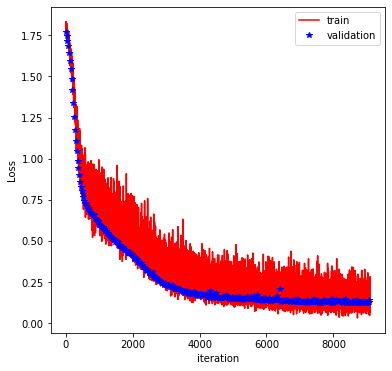

In [15]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 25 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

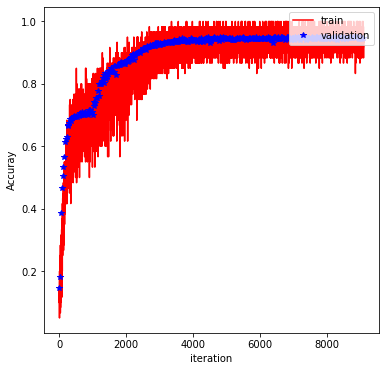

In [16]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 25 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [17]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-crnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-crnn/har.ckpt
Test accuracy: 0.884354
